## Task 1: Photometric Stereo (30 pts)

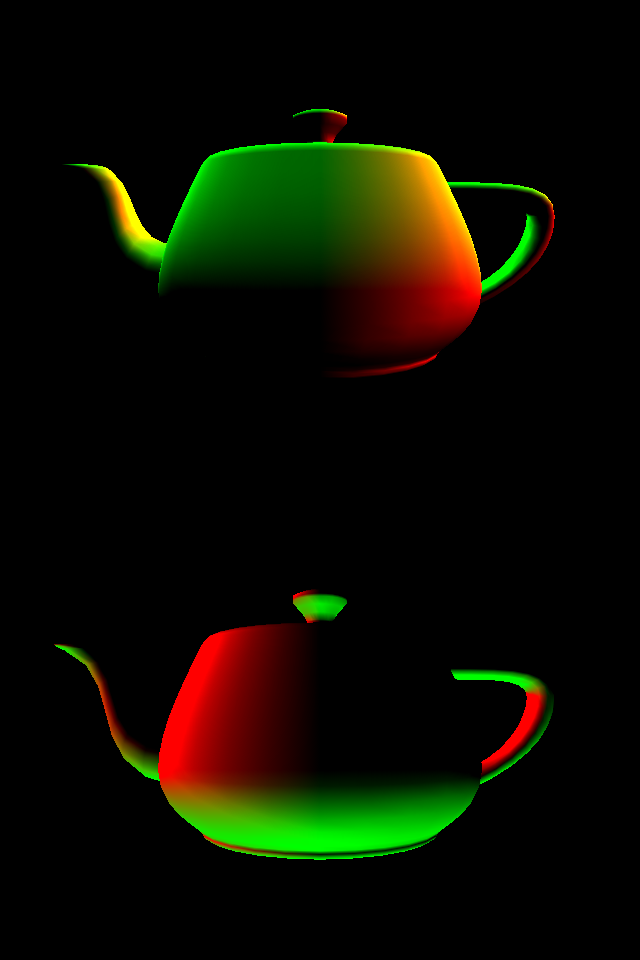

In [1]:
from IPython.display import Image
import numpy as np
import cv2

L = np.array([
    [ 0,-1, 1],
    [ 1, 1, 1],
    [-1, 1, 1]
])

imgs = [
    cv2.imread('2_photometricstereo/teapot_0_-1_1.png', 0),
    cv2.imread('2_photometricstereo/teapot_1_1_1.png', 0),
    cv2.imread('2_photometricstereo/teapot_-1_1_1.png', 0)
]

(h, w) = imgs[0].shape
output_positive_img = np.zeros((h,w,3), np.float32)
output_negative_img = np.zeros((h,w,3), np.float32)

L_inv = np.linalg.inv(L)
for y in range(0, h):
    for x in range(0, w):
        I = np.array([imgs[0][y,x], imgs[1][y,x], imgs[2][y,x]])
        N = np.dot(L_inv, I)
        if N[2] != 0:
            N = (N/N[2])*255
            if N[1] > 0:
                output_positive_img[y,x,1] = N[1]
            else:
                output_negative_img[y,x,1] = -N[1]
            
            if N[0] > 0:
                output_positive_img[y,x,2] = N[0]
            else:
                output_negative_img[y,x,2] = -N[0]

output_img = np.zeros((h*2,w,3),np.float32)
output_img[:h,:,:] = output_positive_img[:,:,:]
output_img[h:2*h,:] = output_negative_img[:,:,:]
output_path = 'output/task1.png'
cv2.imwrite(output_path,output_img)
Image(output_path)
        

## Task 2: Relighting (30 pts)

In [52]:
from os import listdir
from os.path import isfile, join

data_path = '1_relighting/data'
data_files = [join(data_path, f) for f in listdir(data_path) if isfile(join(data_path, f))]

prefix = 'teapot_'
ext = '.png'
images_with_angles = []
for img_path in data_files:
    img = cv2.imread(img_path)
    angles = img_path[img_path.find(prefix)+len(prefix):img_path.find(ext)].split('_')
    rad_angles = [np.radians(float(angles[0])), np.radians(float(angles[1]))]
    images_with_angles.append([img, rad_angles[0], -rad_angles[1]])

In [50]:
def relighting(imgs_theta_phi, probe):
    img_shape = imgs_theta_phi[0][0].shape
    output_img = np.zeros(img_shape, np.float32)
    (probe_h, probe_w, probe_c) = probe.shape
    for img, theta, phi in imgs_theta_phi:
        u_norm, v_norm = compute_spherical_coords(theta, phi)
        u, v = int((u_norm+1.)*probe_w/2.), int((v_norm+1.)*probe_h/2.)
        output_img += img * (probe[v,u]/255.)
    return output_img/len(imgs_theta_phi)

def compute_spherical_coords(theta, phi):
    dx = np.cos(phi)*np.sin(theta)
    dy = np.sin(phi)
    dz = -np.cos(phi)*np.cos(theta)
    if np.sqrt(dx**2+dy**2) == 0:
        r = 0.
    else:
        r = (1./np.pi)*np.arccos(dz)/np.sqrt(dx**2+dy**2)
    return dx*r, dy*r
    
    

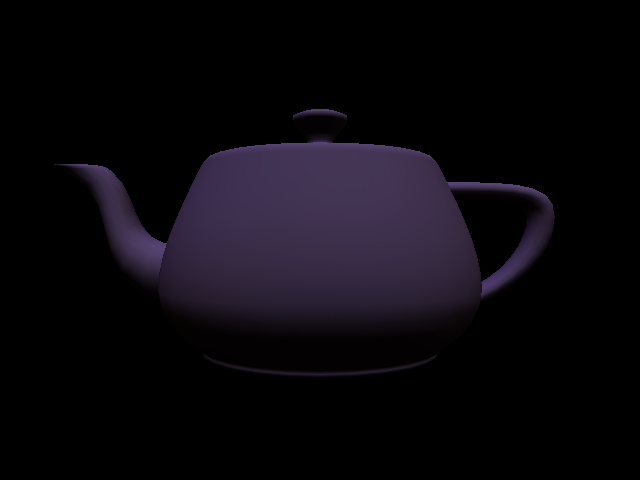

In [53]:
grace_probe = cv2.imread('1_relighting/grace_probe.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

output_img = relighting(images_with_angles, grace_probe)

output_path = 'output/task2_grace.png'
cv2.imwrite(output_path, output_img)
Image(output_path)

## Task 3: Real Dataset (20 pts)

Dataset from http://gl.ict.usc.edu/Data/LightStage/

In [57]:
data_path = '3_realdata/knight_fighting/data'
data_files = [join(data_path, f) for f in listdir(data_path) if isfile(join(data_path, f))]
data_files.sort()
with open('3_realdata/knight_fighting/light_directions.txt') as ld_file:
    lines = ld_file.readlines()
    light_directions = [map(float, line.rstrip().split()[1:]) for line in lines]
    light_directions = [[-ld[0], ld[1], ld[2]] for ld in light_directions]
with open('3_realdata/knight_fighting/light_intensities.txt') as li_file:
    lines = li_file.readlines()
    light_intensities = [map(float, line.rstrip().split()[1:][::-1]) for line in lines]

images_with_lightinfo = zip(data_files, light_directions, light_intensities)

In [55]:
def relighting_realdata(images_info, probe):
    img_shape = cv2.imread(images_info[0][0]).shape
    output_img = np.zeros(img_shape, np.float32)
    (probe_h, probe_w, probe_c) = probe.shape
    for img_path, ld, li in images_info:
        img = cv2.imread(img_path)
        dx, dy, dz = ld
        if np.sqrt(dx**2+dy**2) == 0:
            r = 0.
        else:
            r = (1./np.pi)*np.arccos(dz)/np.sqrt(dx**2+dy**2)
        u_norm, v_norm = dx*r, dy*r
        u, v = int((u_norm+1.)*probe_w/2.), int((v_norm+1.)*probe_h/2.)
        output_img += img * ((probe[v,u]/255.)*li)
    return output_img/30

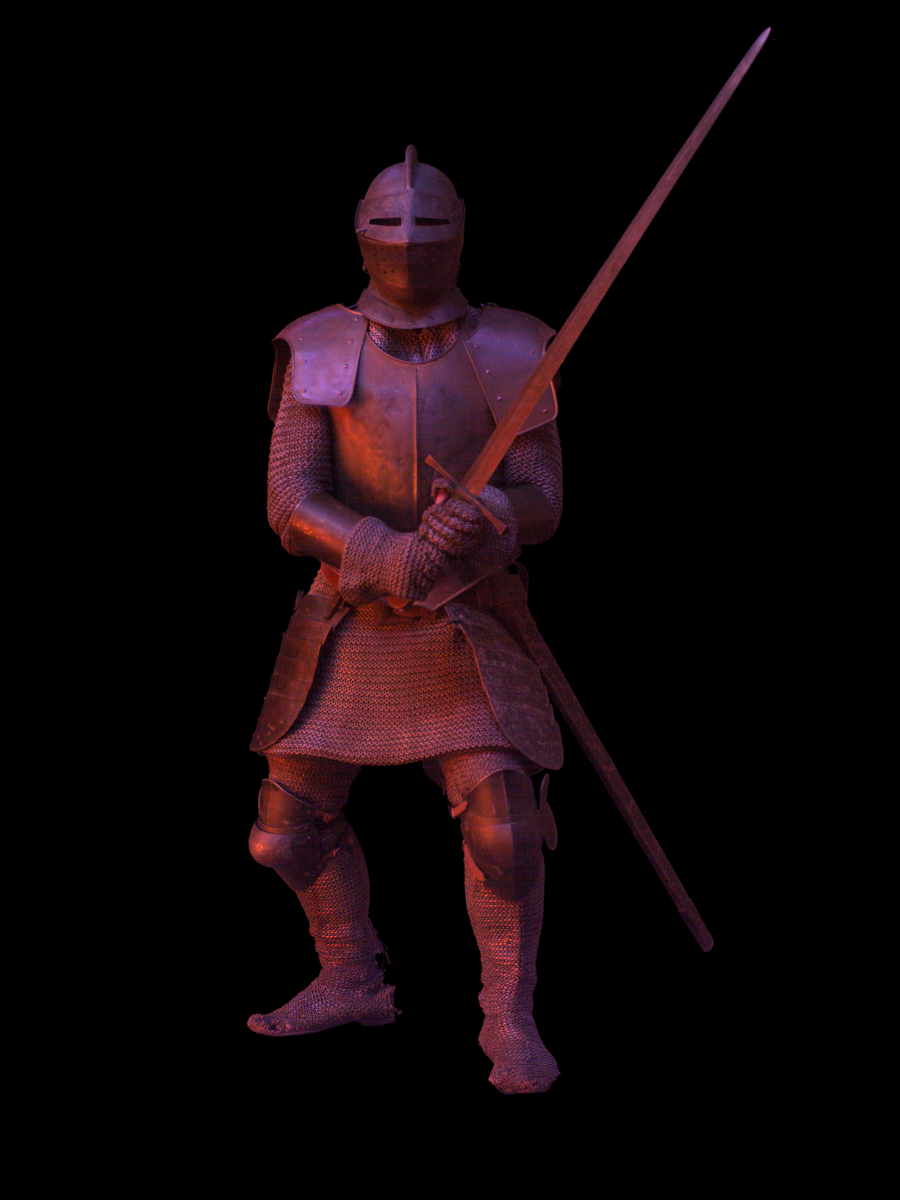

In [58]:
grace_probe = cv2.imread('1_relighting/grace_probe.exr', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
#grace_probe = cv2.imread('1_relighting/grace_probe_tm.png')

output_img = relighting_realdata(images_with_lightinfo, grace_probe)

output_path = 'output/task3_grace.png'
cv2.imwrite(output_path, output_img)
Image(output_path)